### Data explanation and Visualization
Before we can process the data set, we need to understand the general situation of the dataset, including the size of the data set, the content of each column, the type of data (integer type or float(double) type), the content of each column, the relationship between each row.

In this step, we randomly select a pair of data files (record files for StepMixed and CSV) to check.

In [67]:
# import data processing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# pandas library for data analysis.
# numpy library for numerical operations, like matrix multiplication, etc.
# matplotlib library for data visualization.

import os

# os library for changing directory, listing files, etc.

In [68]:
# check the directory structure of data folder
data_rootpath = ".\data"
data_file_cnt = 0
for dir_name, sub_dir_list, file_list in os.walk(data_rootpath):
    print("Found directory: %s" % dir_name)
    for file_name in file_list:
        print('\t%s' % file_name)
        data_file_cnt += 1
print("data file count: %d" % data_file_cnt)

# the number of person is 9
# the number of data file is 57
# 56 for sum of stepMixed and csv feature data
# 1 for the testdata

Found directory: .\data
	testdata.csv
Found directory: .\data\person_10
	awindaRecording_20230403172013.csv.stepMixed
	awindaRecording_20230403172403.csv.stepMixed
	awindaRecording_20230403173039.csv.stepMixed
	awindaRecording_20230403173917.csv.stepMixed
	ClippedawindaRecording_20230403172013.csv
	ClippedawindaRecording_20230403172403.csv
	ClippedawindaRecording_20230403173039.csv
	ClippedawindaRecording_20230403173917.csv
Found directory: .\data\person_11
	awindaRecording_20230403142813.csv.stepMixed
	awindaRecording_20230403143345.csv.stepMixed
	awindaRecording_20230403144010.csv.stepMixed
	awindaRecording_20230403144515.csv.stepMixed
	awindaRecording_20230403151559.csv.stepMixed
	awindaRecording_20230403152221.csv.stepMixed
	awindaRecording_20230403153107.csv.stepMixed
	ClippedawindaRecording_20230403142813.csv
	ClippedawindaRecording_20230403143345.csv
	ClippedawindaRecording_20230403144010.csv
	ClippedawindaRecording_20230403144515.csv
	ClippedawindaRecording_20230403151559.csv
	

In [69]:
# read the feature data file
# the data file is csv format
sample_feature_data = pd.read_csv("./data/person_2/ClippedawindaRecording_20230217132921.csv")
sample_feature_data.head()

# the feature data has 7 columns
# Activity, AccelX, AccelY, AccelZ, GyroX, GyroY, GyroZ

,Activity,AccelX_5,AccelY_5,AccelZ_5,GyroX_5,GyroY_5,GyroZ_5
0,0,0.148915,4.705827,8.557376,-0.013430,-0.001028,0.017995
1,0,0.202848,4.666829,8.485154,-0.027897,-0.000346,0.016360
2,0,0.232652,4.668847,8.412815,-0.038700,0.023742,0.001388
3,0,0.194148,4.665260,8.463220,-0.049840,0.054852,-0.014097
4,0,0.118559,4.698190,8.585538,-0.061949,0.075178,-0.022977


<Axes: >

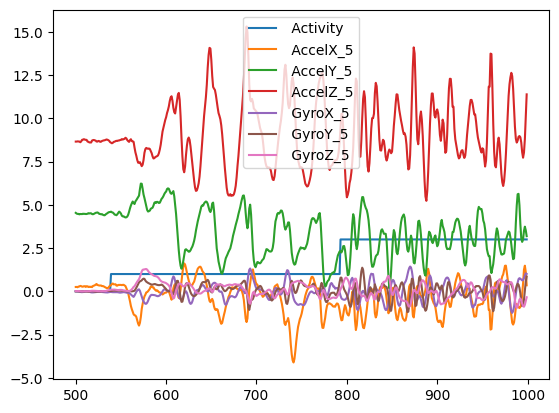

In [70]:
# visualize the part of feature data
sample_feature_data.iloc[500:1000, :].plot()

# can find that data generally has a periodic pattern, but there are some noise, the change is not obvious
# so we need to preprocess the data with noise filter, and rescale the data.

In [71]:
# read the stepMixed data file
# the data file is csv format.
# after a simple check like open with text editor, then find each row is separated by a comma
sample_step_data = pd.read_csv("./data/person_2/awindaRecording_20230217132921.csv.stepMixed", header=None)
sample_step_data.head()

# theres is no header at the start of the file, so param header=None
# as the description from README.md, the stepMixed data has 2 columns
# the first column is the start step indices, the second column is the end step indices

,0,1
0,557,606
1,650,690
2,731,767
3,797,819
4,842,861


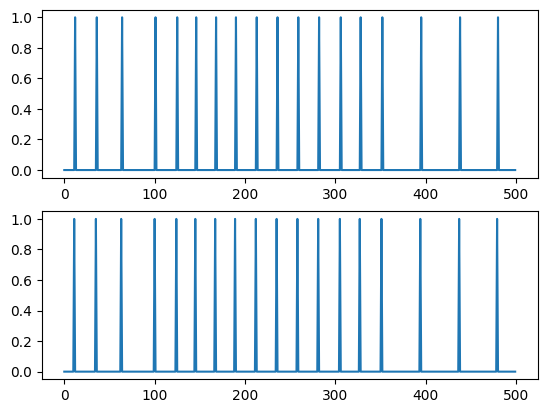

In [72]:
# visualize the part of stepMixed data
# as the stepMixed data is the indices of feature data, each row describe a step.
# it is not as long as the feature data, so we can not plot it directly.
# on the other hand, we can expand the stepMixed data to the same length as the record data.
visual_start_step_data = np.zeros((sample_feature_data.shape[0], 1))
visual_end_step_data = np.zeros((sample_feature_data.shape[0], 1))
for i in range(sample_step_data.shape[0]):
    visual_start_step_data[sample_step_data.iloc[i, 0]] = 1
    visual_end_step_data[sample_step_data.iloc[i, 1]] = 1
plt.subplot(2, 1, 1)
plt.plot(visual_start_step_data[1000:1500])
plt.subplot(2, 1, 2)
plt.plot(visual_end_step_data[1000:1500])
plt.show()

# the step also has a periodic pattern, and between the start and stop step has small offset.
# generally, the step indices in whole sequence is sparse, we need some ways to make it dense.

### Data preprocessing
In the previous steps, I examined the data, observed that it contained noise, and needed rescale to make the waveform more significant. I will use the index in the stepMixed file as the training label, so we also need to process the label.

(I dropped the **Activity** column as I wont use it as input, actually what I want to do is more like a waveform detection and classification, In practice, I think the **Activity** is post knowledge, cannot be learned in advance, only waveform data can be collected, so I only use waveform data to train neural networks)

First before we start to filter the noise, we shall do frequency analysis with feature data, and then use **Low Pass Filter** to clean some high frequency signals that may be the noise for training, after this, I use **Min-Max Scaler** to rescale the data into the range 0 to 1, the normalization can make data curve easier to recognize or learn.

For the labels, I mentioned before for the sparse of 1s, what I handle this is to simply expend the expected indices list with the range from previous 10 to next 10. 0s in the label list are meaningless, just to fill the gap of the expected indices, so basically we can add the buffer before expected index.

In [73]:
# data preprocessing: filtering
###########################      Low Pass Filter     ###############################
# A Low Pass Filter (LPF) is a type of electronic filter that allows 
# low-frequency signals to pass through while attenuating or reducing the amplitude 
# of high-frequency signals. In other words, it allows signals 
# below a certain cutoff frequency to pass through relatively unchanged, 
# while attenuating signals above that frequency.
####################################################################################
from scipy.signal import butter, lfilter
# fs: sampling frequency (Hz)
# cutoff: cutoff frequency (Hz)
# order: order of the filter (default: 5)

# params set for filter
fs = 50.0 # Hz
cutoff = 3 # Hz
order = 3
# fs is 50Hz, which I selected a general sampleing frequency of the IMU sensor.
# cutoff frequency is 3Hz
# when sensor is hold by hand, the frequency can be around 3Hz
# so we set the cutoff frequency to 3Hz to filter the high frequency noise
# 3 order filter is enough for this task

def butter_lowpass(cutoff, fs, order=5):
    # nyq: Nyquist frequency
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    # get the numerator and denominator of the filter
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    # get the numerator and denominator of the filter
    b, a = butter_lowpass(cutoff, fs, order=order)
    # filter the data
    y = lfilter(b, a, data)
    return y


<Axes: >

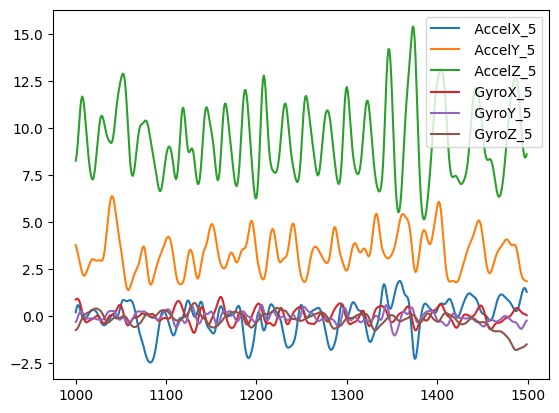

In [74]:
# data preprocessing: filtering
# drop the Activity column
sample_feature_data_no_activity = sample_feature_data.drop([' Activity'], axis=1)
# filter all the columns
sample_feature_data_filtered = sample_feature_data_no_activity.apply(lambda x: butter_lowpass_filter(x, cutoff, fs, order))
# plot the filtered data
sample_feature_data_filtered.iloc[1000:1500, :].plot()

##### Min-Max Scaler
In order to eliminate the dimensional effects between data features, we need to normalize the features so that they are comparable between different indicators.
Normalizing features of numerical types can unify all features into a roughly identical numerical interval.

Formula as following:

$$
X_{std} = \frac{X-X_{min}}{X_{max}-X_{min}} \\
X_{rescaled} = X_{std} \cdot \left(max - min\right) + min
$$

**Definition:**

Symbol | Definition
:--------: | :-----
$X$ | The vector.
$X_{std}$ | Standardized result.
$X_{rescaled}$ | Normalized result.
$X_{max}$ | The minimum value of the vector.
$X_{min}$ | The maximum value of the vector.
$max$ | The maximum value of the interval to normalize to.
$min$ | The minimum value of the interval to normalize to.



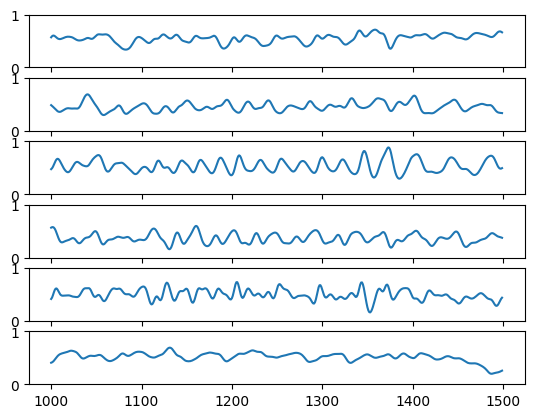

In [75]:
# data preprocessing: rescale
# rescale the data to the range of [0, 1]
def MinMax_Scaler(X, feature_range=(0, 1)):
    X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    X_rescaled = X_std * (feature_range[1] - feature_range[0]) + feature_range[0]
    return X_rescaled

sample_feature_data_filtered_rescaled = MinMax_Scaler(sample_feature_data_filtered)

# plot the rescaled data with y range of [0, 1]
plt.subplot(6, 1, 1)
plt.plot(sample_feature_data_filtered_rescaled.iloc[1000:1500, 0])
plt.ylim(0, 1)
plt.subplot(6, 1, 2)
plt.plot(sample_feature_data_filtered_rescaled.iloc[1000:1500, 1])
plt.ylim(0, 1)
plt.subplot(6, 1, 3)
plt.plot(sample_feature_data_filtered_rescaled.iloc[1000:1500, 2])
plt.ylim(0, 1)
plt.subplot(6, 1, 4)
plt.plot(sample_feature_data_filtered_rescaled.iloc[1000:1500, 3])
plt.ylim(0, 1)
plt.subplot(6, 1, 5)
plt.plot(sample_feature_data_filtered_rescaled.iloc[1000:1500, 4])
plt.ylim(0, 1)
plt.subplot(6, 1, 6)
plt.plot(sample_feature_data_filtered_rescaled.iloc[1000:1500, 5])
plt.ylim(0, 1)
plt.show()

# After rescalled, the data is in the range of [0, 1]
# As the plot shows, the periodic pattern or phase of the data is more obvious.

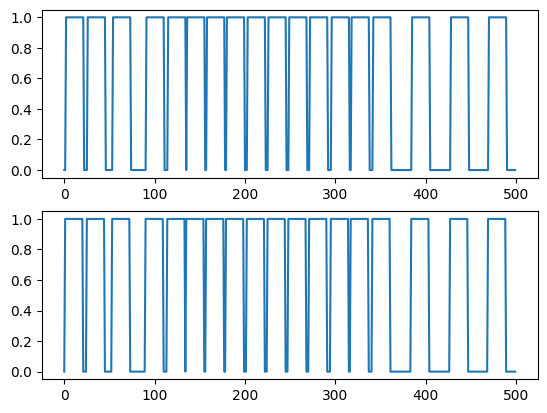

value counts of start step data:
1.0    11999
0.0    11588
Name: count, dtype: int64
value counts of end step data:
1.0    11999
0.0    11588
Name: count, dtype: int64


In [76]:
# data preprocessing: stepMixed data
# expand the expected indices by from pervious 10 to next 10 indices
start_step_indices = []
end_step_indices = []
for i in range(sample_step_data.shape[0]):
    start_step_indices.extend(range(sample_step_data.iloc[i, 0] - 10, sample_step_data.iloc[i, 0] + 10))
    end_step_indices.extend(range(sample_step_data.iloc[i, 1] - 10, sample_step_data.iloc[i, 1] + 10))

# expand the stepMixed data to the same length as the record data
label_start_step_data = np.zeros((sample_feature_data_filtered_rescaled.shape[0], 1))
label_end_step_data = np.zeros((sample_feature_data_filtered_rescaled.shape[0], 1))

# set the indices to 1s
label_start_step_data[start_step_indices] = 1
label_end_step_data[end_step_indices] = 1

# plot the expanded stepMixed data
plt.subplot(2, 1, 1)
plt.plot(label_start_step_data[1000:1500])
plt.subplot(2, 1, 2)
plt.plot(label_end_step_data[1000:1500])
plt.show()

label_step_data = np.concatenate((label_start_step_data, label_end_step_data), axis=1)

print("value counts of start step data:")
print(pd.DataFrame(label_step_data[:, 0]).value_counts())
print("value counts of end step data:")
print(pd.DataFrame(label_step_data[:, 1]).value_counts())

# As a result, the stepMixed data is more dense than the pervious one.
# The disadvantage of the sparse prediction data is 
# that in the model prediction process, even if the model predicts all 0
# it can get good results, so the model becomes lazy to predict 1
# resulting in the final prediction results become worse.

In [77]:
# concatenate the feature data and label data
sample_feature_data_filtered_rescaled_with_label = np.concatenate((sample_feature_data_filtered_rescaled, label_step_data), axis=1)
print(sample_feature_data_filtered_rescaled_with_label.shape)
pd.DataFrame(sample_feature_data_filtered_rescaled_with_label).head()

(23587, 8)


,0,1,2,3,4,5,6,7
0,0.552965,0.192517,0.000000,0.362380,0.523032,0.554545,0.0,0.0
1,0.553310,0.201689,0.012273,0.362286,0.523024,0.554632,0.0,0.0
2,0.554243,0.224459,0.042720,0.361999,0.523048,0.554830,0.0,0.0
3,0.555914,0.262111,0.093006,0.361399,0.523290,0.555087,0.0,0.0
4,0.558177,0.311130,0.158420,0.360408,0.524101,0.555261,0.0,0.0


### Time Series data processing
The whole data set is collected by time, and the task is to use the time series to predict the start step or end step for next coming time step.

Based on target, we shall get full use of the pattern that shown by time series, then we can simply use sliding windows for each time step, to extract sequence characteristics. 

A key parameter for a time series is **seq_len**, we set **seq_len** to 50 in the test, so we set the length of the time window to 50. The goal is to obtain the number of sequences equal to the number of original points, therefore, the additional (**seq_len-1**) * 0 is required before the original sequence, to ensure that the previous **seq_len-1** sequences satisfy the fixed length of the sequence.

As the task, we can input per sequence with length in 50 (**seq_len**), and predict if the final time step is start step, or end step.

the shape after processing: (23587, 50, 6).
the shape of the data with label: feature: (50, 6), label: (2,).


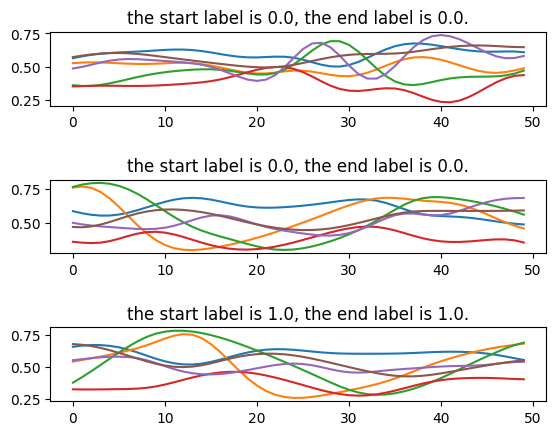

In [78]:
# split the sequences
seq_len = 50
feature_dim = 6
# additional 0 padding at the start of the original data (feature)
feature_data = sample_feature_data_filtered_rescaled.values
sequenctial_data = []
for i in range(len(feature_data)):
    if i - seq_len + 1 < 0:
        padding = np.zeros((seq_len, feature_dim))
        padding[seq_len-1-i:] = feature_data[:i+1]
        sequenctial_data.append(padding)
    else:
        sequenctial_data.append(feature_data[i-seq_len+1:i+1])
sequenctial_data = np.array(sequenctial_data)
print("the shape after processing: {}.".format(sequenctial_data.shape))

# concatenate the feature data and label data using list
data_with_label = []
for i in range(len(sequenctial_data)):
    data_with_label.append([sequenctial_data[i], label_step_data[i]])

print("the shape of the data with label: feature: {}, label: {}.".format(data_with_label[0][0].shape, data_with_label[0][1].shape))

# shuffle the data
np.random.shuffle(data_with_label)

# randomly select 3 sequences to plot
plt.subplot(3, 1, 1)
plt.plot(data_with_label[0][0])
plt.title("the start label is {}, the end label is {}.".format(data_with_label[0][1][0], data_with_label[0][1][1]))
plt.subplot(3, 1, 2)
plt.plot(data_with_label[1][0])
plt.title("the start label is {}, the end label is {}.".format(data_with_label[1][1][0], data_with_label[1][1][1]))
plt.subplot(3, 1, 3)
plt.plot(data_with_label[2][0])
plt.title("the start label is {}, the end label is {}.".format(data_with_label[2][1][0], data_with_label[2][1][1]))
plt.subplots_adjust(hspace=1)
plt.show()

# after series processing, the characteristics of time series still 
# exist in each sequence. and the shape of the data is (n, seq_len, feature_dim)
# shuffle process should be always after concatenating the feature data and label data
# otherwise, the label data will be shuffled and the model will not be able to learn the correct label

In [79]:
# batchify the data
batch_size = 128
data_batches = []

for i in range(0, len(data_with_label), batch_size):
    data_batches.append(data_with_label[i:i+batch_size])
print("the number of batches: {}.".format(len(data_batches)))

# by improving the using of the GPU memory, batch can be stored locally as a file.
# when the batch is needed, it can be loaded from the file.
# for doing this, we use the pickle library
import pickle

# save the batch data
batch_rootpath = "./cache/"

if not os.path.exists(batch_rootpath):
    os.makedirs(batch_rootpath)

batch_cnt = 0
for item in data_batches:
    with open(batch_rootpath + "batch_{}.pkl".format(batch_cnt), "wb") as f:
        pickle.dump(item, f)
    batch_cnt += 1
print("{} batches have been saved in {}.".format(batch_cnt, batch_rootpath))

# check the saved batch data
with open(batch_rootpath + "batch_0.pkl", "rb") as f:
    batch_data = pickle.load(f)
    print("\nCheck batch: the shape of the batch data: {}.".format(len(batch_data)))
    print("Check batch: the shape of the feature data: {}.".format(batch_data[0][0].shape))
    print("Check batch: the shape of the label data: {}.".format(batch_data[0][1].shape))

# so far, the data preprocessing is finished.
# we have done with the following steps:
# 1. load the all data
# 2. filter and rescale the feature data
# 3. expand the stepMixed data as label
# 4. split the sequences
# 5. concatenate the feature sequences and label data
# 6. shuffle the sequences
# 7. batchify the sequences and save the batch
# in the next step is to build the model and train the model.

the number of batches: 185.
185 batches have been saved in ./cache/.

Check batch: the shape of the batch data: 128.
Check batch: the shape of the feature data: (50, 6).
Check batch: the shape of the label data: (2,).


In [80]:
# if you want to remove the content in the cache folder
# but keep the folder, you can use the following code
import shutil
def clean_cache():
    shutil.rmtree(batch_rootpath, ignore_errors=True)
    # recreate the folder
    os.makedirs(batch_rootpath)

### RNN models training and test
#### What is Recurrent neural network (RNN)?
A recurrent neural network (RNN) is a class of artificial neural networks where connections between nodes can create a cycle, allowing **output from some nodes to affect subsequent input to the same nodes**. This allows it to **exhibit temporal dynamic behavior**. 

Derived from feedforward neural networks, RNNs can use their internal state (memory) to process variable length sequences of inputs. This makes them applicable to tasks such as unsegmented, connected handwriting recognition or speech recognition. Recurrent neural networks are theoretically Turing complete and can run arbitrary programs to process arbitrary sequences of inputs.

The Ising model (1925) by Wilhelm Lenz and Ernst Ising was a first RNN architecture that did not learn. Shun'ichi Amari made it adaptive in 1972. This was also called the Hopfield network (1982). See also David Rumelhart's work in 1986. In 1993, a neural history compressor system solved a "Very Deep Learning" task that required more than 1000 subsequent layers in an RNN unfolded in time.

(from https://en.wikipedia.org/wiki/Recurrent_neural_network)


#### What is the Long-Short Term Memory (LSTM)?
Long short-term memory (LSTM) is an artificial recurrent neural network (RNN) architecture used in the field of deep learning. Unlike standard feedforward neural networks, LSTM has feedback connections. It can not only process single data points (such as images), but also entire sequences of data (such as speech or video). For example, LSTM is applicable to tasks such as unsegmented, connected handwriting recognition, speech recognition and anomaly detection in network traffic or IDSs (intrusion detection systems).

LSTM was proposed in 1997 by Sepp Hochreiter and Jürgen Schmidhuber. The first LSTM network was successfully applied to real data in 2000, in a handwriting recognition task. LSTM achieved human-level performance on many tasks related to time series, including predicting the next word in a sentence, predicting upcoming notes in a piece of music, and predicting the trend of a time series or stock market exchange rate.

(from https://en.wikipedia.org/wiki/Long_short-term_memory)

#### What is the Gated Recurrent Unit (GRU)?
Gated recurrent units (GRUs) are a gating mechanism in recurrent neural networks, introduced in 2014 by Kyunghyun Cho et al. The GRU is like a long short-term memory (LSTM) with a forget gate, but has fewer parameters than LSTM, as it lacks an output gate.

based on the LSTM, GRU is a simplified version of LSTM, which is more efficient and faster than LSTM. 

(from https://en.wikipedia.org/wiki/Gated_recurrent_unit)

Come back to the task, we can use RNN to train the time series data, and predict the start step or end step for next coming time step. We firstly use the **LSTM** to train the data, and then use **GRU** to train the data, and compare the results.

In [81]:
# import internal libraries
import os
import time

# import the pytorch library
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader

# import utils
import re               # regular expression
from tqdm import tqdm   # progress bar
import pickle           # load batch data


In [27]:
# read the batch path
batch_rootpath = "./cache/"
batch_files = os.listdir(batch_rootpath)
print("the number of batch files: {}.".format(len(batch_files)))

# sort paths by batch number, using regular expression
# the reason is that the we should always concern about 
# if the order of the batches affect the training result.
# As the shuffle is done in seqs level, we should make sure that 
# the order of the batches is not the reason that affect the training result.
batch_files = sorted(batch_files, key=lambda x: int(re.findall(r"\d+", x)[0]))

# split the train and validation batches by the train_ratio
train_ratio = 0.8
train_batch_files = batch_files[:int(len(batch_files)*train_ratio)]
valid_batch_files = batch_files[int(len(batch_files)*train_ratio):]
print("the number of train batch files: {}.".format(len(train_batch_files)))
print("the number of validation batch files: {}.".format(len(valid_batch_files)))

# we can only load the path of the batch data, and load the batch data when it is needed.
# and the next is to define the models

the number of batch files: 185.
the number of train batch files: 148.
the number of validation batch files: 37.


In [41]:
# define the general parts and variables of the models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define general network structures for models
# singleMLP output the start and end label with one MLP
class outputLayer_singleMLP(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.rgr = nn.Sequential(
                        nn.Linear(input_size, 128),
                        nn.Tanh(),
                        nn.Linear(128, output_size))
    
    def forward(self, x):
        pred = self.rgr(x)
        return pred

# doubleMLP output the start and end label with two MLPs
class outputLayer_doubleMLP(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.rgr1 = nn.Sequential(
                        nn.Linear(input_size, 128),
                        nn.Tanh(),
                        nn.Linear(128, output_size))
        self.rgr2 = nn.Sequential(
                        nn.Linear(input_size, 128),
                        nn.Tanh(),
                        nn.Linear(128, output_size))
    
    def forward(self, x):
        pred1 = self.rgr1(x)
        pred2 = self.rgr2(x)
        return pred1, pred2
    
# for prediction task, we use fully connected layers to predict the start and end label
# however, the start and end label are separate,
# in practice, they can be predicted together or separately
# by singleMLP or doubleMLP.

In [42]:
# define the RNN models
class model_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, isBidirectional=False, dropout=None):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        if isBidirectional:
            self.num_directions = 2
        else:
            self.num_directions = 1

        if dropout is not None:
            self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True, bidirectional=isBidirectional, dropout=dropout)
        else:
            self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True, bidirectional=isBidirectional)
        
        # output layer
        self.fc = outputLayer_doubleMLP(self.num_directions * self.hidden_size, output_size)

    def forward(self, x):
        # shape of x : (batch_size, seq_len, feature_dim)
        output, _ = self.lstm(x)
        # shape of output: (batch_size, seq_len, hidden_size * num_directions)
        if self.num_directions == 2:
            # when using bidirectional LSTM, the output shape is (batch_size, seq_len, hidden_size * 2)
            # we need to split the output into two directions
            output = output.contiguous().view(output.size(0), output.size(1), 2, -1)
            # take average of the two directions
            output = torch.mean(output, dim=2) # shape of output: (batch_size, seq_len, hidden_size)

        out1, out2 = self.fc(output)
        pred = torch.cat((out1[:, -1, :], out2[:, -1, :]), 1)
        return pred
    
    def save(self, path):
        torch.save(self.state_dict(), path)
    
    def load(self, path):
        self.load_state_dict(torch.load(path, map_location=torch.device(device)))

    def name(self):
        return self.__class__.__name__


class model_GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, isBidirectional=False, dropout=None):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        if isBidirectional:
            self.num_directions = 2
        else:
            self.num_directions = 1

        if dropout is not None:
            self.gru = nn.GRU(self.input_size, self.hidden_size, self.num_layers, batch_first=True, bidirectional=isBidirectional, dropout=dropout)
        else:
            self.gru = nn.GRU(self.input_size, self.hidden_size, self.num_layers, batch_first=True, bidirectional=isBidirectional)
        
        # output layer
        self.fc = outputLayer_doubleMLP(self.num_directions * self.hidden_size, output_size)

    def forward(self, x):
        # shape of x : (batch_size, seq_len, feature_dim)
        output, _ = self.gru(x)
        # shape of output: (batch_size, seq_len, hidden_size * num_directions)
        if self.num_directions == 2:
            # when using bidirectional LSTM, the output shape is (batch_size, seq_len, hidden_size * 2)
            # we need to split the output into two directions
            output = output.contiguous().view(output.size(0), output.size(1), 2, -1)
            # take average of the two directions
            output = torch.mean(output, dim=2) # shape of output: (batch_size, seq_len, hidden_size)

        out1, out2 = self.fc(output)
        pred = torch.cat((out1[:, -1, :], out2[:, -1, :]), 1)
        return pred
    
    def save(self, path):
        torch.save(self.state_dict(), path)
    
    def load(self, path):
        self.load_state_dict(torch.load(path, map_location=torch.device(device)))

    def name(self):
        return self.__class__.__name__

#### Average Precision (AP)

In [40]:
# calculate the precision, recall, and average precision score.
import sklearn.metrics as metrics   

def precision_score(y_true, y_pred):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)

    y_pred[y_pred >= 0.5] = 1.0
    y_pred[y_pred < 0.5] = 0.0

    TP = np.sum(y_true * y_pred)
    FP = np.sum((1.0 - y_true) * y_pred)
    return TP / (TP + FP)

def recall_score(y_true, y_pred):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)

    y_pred[y_pred >= 0.5] = 1.0
    y_pred[y_pred < 0.5] = 0.0

    TP = np.sum(y_true * y_pred)
    FN = np.sum(y_true * (1.0 - y_pred))
    return TP / (TP + FN)

def average_precision_score(y_true, y_pred):
    precisions = []
    recalls = []
    thresholds = np.arange(start=0.1, stop=0.9, step=0.001)

    for threshold in thresholds:
        y_pred_threshold = [1.0 if y >= threshold else 0.0 for y in y_pred]

        precision = precision_score(y_true, y_pred_threshold)
        recall = recall_score(y_true, y_pred_threshold)

        precisions.append(precision)
        recalls.append(recall)

    precisions.append(1.0)
    recalls.append(0.0)

    avg_precision = 0.0

    for i in range(len(precisions) - 1):
        avg_precision += (recalls[i] - recalls[i + 1]) * precisions[i]

    return avg_precision

# implemented AP score
# but I found it not working well.
# so I may use the sklearn.metrics.average_precision_score instead. :(

#### Binary Cross Entropy Loss
The binary cross entropy loss is defined as follows:

$$
Loss = -\frac{1}{N}\sum_{i=1}^{N}\left[y_i\log\left(\hat{y}_i\right) + \left(1-y_i\right)\log\left(1-\hat{y}_i\right)\right]
$$

**Definition:**

Symbol | Definition
:--------: | :-----
$N$ | The number of samples.
$y_i$ | The label of the $i$-th sample.
$\hat{y}_i$ | The predicted value of the $i$-th sample.


In [55]:
# define general training function
model_save_path = './models/'
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)

def train(model, num_epochs, criterion, optimizer, scheduler):
    total_train_loss = []
    total_train_score = []
    total_val_loss = []
    total_val_score = []
    for e in range(num_epochs):
        avg_train_loss = 0
        avg_train_score = 0
        avg_val_loss = 0
        avg_val_score = 0

        # shuffle batch
        np.random.shuffle(train_batch_files)
        np.random.shuffle(valid_batch_files)

        with tqdm(total=len(train_batch_files)+len(valid_batch_files)) as pbar:

            # training
            pbar.set_description('Epoch: {}/{}...'.format(e+1, num_epochs)+'Training...')
            for batch_file in train_batch_files:
                # train mode
                model.train()

                # load batch data
                with open(batch_path+batch_file, 'rb') as f:
                    batch_data = pickle.load(f)
                feature = [row[0] for row in batch_data]
                label = [row[1] for row in batch_data]
                feature = torch.tensor(feature, dtype=torch.float32).to(device)
                label = torch.tensor(label, dtype=torch.float32).to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                pred = model(feature)

                # backward
                loss = criterion(pred, label)
                avg_train_loss += loss.item()
                loss.backward()

                # update parameters
                optimizer.step()

                # calculate the score
                pred = torch.sigmoid(pred)
                AP_start = metrics.average_precision_score(
                    label[:, 0].reshape(-1, 1).cpu().detach().numpy(),
                    pred[:, 0].reshape(-1, 1).cpu().detach().numpy()
                )
                AP_end = metrics.average_precision_score(
                    label[:, 1].reshape(-1, 1).cpu().detach().numpy(),
                    pred[:, 1].reshape(-1, 1).cpu().detach().numpy()
                )
                avg_train_score += (AP_start + AP_end) / 2.0

                pbar.update(1) # update progress bar
            
            # validation
            pbar.set_description('Epoch: {}/{}...'.format(e+1, num_epochs)+'Validation...')
            with torch.no_grad():
                for batch_file in valid_batch_files:
                    # eval mode
                    model.eval()

                    # load batch data
                    with open(batch_path+batch_file, 'rb') as f:
                        batch_data = pickle.load(f)
                    feature = [row[0] for row in batch_data]
                    label = [row[1] for row in batch_data]
                    feature = torch.tensor(feature, dtype=torch.float32).to(device)
                    label = torch.tensor(label, dtype=torch.float32).to(device)

                    # forward
                    pred = model(feature)

                    # calculate the loss
                    loss = criterion(pred, label)
                    avg_val_loss += loss.item()

                    # calculate the score
                    pred = torch.sigmoid(pred)
                    AP_start = metrics.average_precision_score(
                        label[:, 0].reshape(-1, 1).cpu().detach().numpy(),
                        pred[:, 0].reshape(-1, 1).cpu().detach().numpy()
                    )
                    AP_end = metrics.average_precision_score(
                        label[:, 1].reshape(-1, 1).cpu().detach().numpy(),
                        pred[:, 1].reshape(-1, 1).cpu().detach().numpy()
                    )
                    avg_val_score += (AP_start + AP_end) / 2.0

                    pbar.update(1) # update progress bar

        total_train_loss.append(avg_train_loss / len(train_batch_files))
        total_train_score.append(avg_train_score / len(train_batch_files))
        total_val_loss.append(avg_val_loss / len(valid_batch_files))
        total_val_score.append(avg_val_score / len(valid_batch_files))
        # print the training and validation loss and score
        epoch_info = 'avg_train_loss: {:.4f}\n'.format(total_train_loss[-1])+\
            'avg_train_score: {:.4f}\n'.format(total_train_score[-1])+\
            'avg_val_loss: {:.4f}\n'.format(total_val_loss[-1])+\
            'avg_val_score: {:.4f}\n'.format(total_val_score[-1])
        print(epoch_info)

        # save the model
        model.save(model_save_path+model.name()+'_epoch{}.pth'.format(e+1))

        # update the learning rate
        scheduler.step()

    # plot the training and validation loss and score
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(total_train_loss, label='train loss')
    plt.plot(total_val_loss, label='val loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(total_train_score, label='train score')
    plt.plot(total_val_score, label='val score')
    plt.legend()
    plt.show()

    # print the best training and validation loss and score
    best_epoch = np.argmin(total_val_loss)
    best_info = '\nBest Epoch: {}\n'.format(best_epoch+1)+\
        'best_train_loss: {:.4f}\n'.format(total_train_loss[best_epoch])+\
        'best_train_score: {:.4f}\n'.format(total_train_score[best_epoch])+\
        'best_val_loss: {:.4f}\n'.format(total_val_loss[best_epoch])+\
        'best_val_score: {:.4f}\n'.format(total_val_score[best_epoch])
    print(best_info)

Epoch: 1/10...Validation...: 100%|██████████| 185/185 [00:15<00:00, 11.65it/s]



Epoch: 1/10...
avg_train_loss: 0.4795
avg_train_score: 0.8660
avg_val_loss: 0.3805
avg_val_score: 0.9156



Epoch: 2/10...Validation...: 100%|██████████| 185/185 [00:15<00:00, 12.23it/s]



Epoch: 2/10...
avg_train_loss: 0.3676
avg_train_score: 0.9226
avg_val_loss: 0.3609
avg_val_score: 0.9296



Epoch: 3/10...Validation...: 100%|██████████| 185/185 [00:14<00:00, 12.47it/s]



Epoch: 3/10...
avg_train_loss: 0.3531
avg_train_score: 0.9284
avg_val_loss: 0.3285
avg_val_score: 0.9406



Epoch: 4/10...Validation...: 100%|██████████| 185/185 [00:14<00:00, 12.33it/s]



Epoch: 4/10...
avg_train_loss: 0.3244
avg_train_score: 0.9394
avg_val_loss: 0.3003
avg_val_score: 0.9488



Epoch: 5/10...Validation...: 100%|██████████| 185/185 [00:14<00:00, 12.41it/s]



Epoch: 5/10...
avg_train_loss: 0.2872
avg_train_score: 0.9511
avg_val_loss: 0.2537
avg_val_score: 0.9628



Epoch: 6/10...Validation...: 100%|██████████| 185/185 [00:14<00:00, 12.34it/s]



Epoch: 6/10...
avg_train_loss: 0.2542
avg_train_score: 0.9609
avg_val_loss: 0.2447
avg_val_score: 0.9659



Epoch: 7/10...Validation...: 100%|██████████| 185/185 [00:14<00:00, 12.34it/s]



Epoch: 7/10...
avg_train_loss: 0.2404
avg_train_score: 0.9658
avg_val_loss: 0.2216
avg_val_score: 0.9725



Epoch: 8/10...Validation...: 100%|██████████| 185/185 [00:14<00:00, 12.34it/s]



Epoch: 8/10...
avg_train_loss: 0.2222
avg_train_score: 0.9700
avg_val_loss: 0.2157
avg_val_score: 0.9747



Epoch: 9/10...Validation...: 100%|██████████| 185/185 [00:15<00:00, 12.19it/s]



Epoch: 9/10...
avg_train_loss: 0.2175
avg_train_score: 0.9720
avg_val_loss: 0.2067
avg_val_score: 0.9763



Epoch: 10/10...Validation...: 100%|██████████| 185/185 [00:15<00:00, 12.23it/s]



Epoch: 10/10...
avg_train_loss: 0.2031
avg_train_score: 0.9758
avg_val_loss: 0.1971
avg_val_score: 0.9797



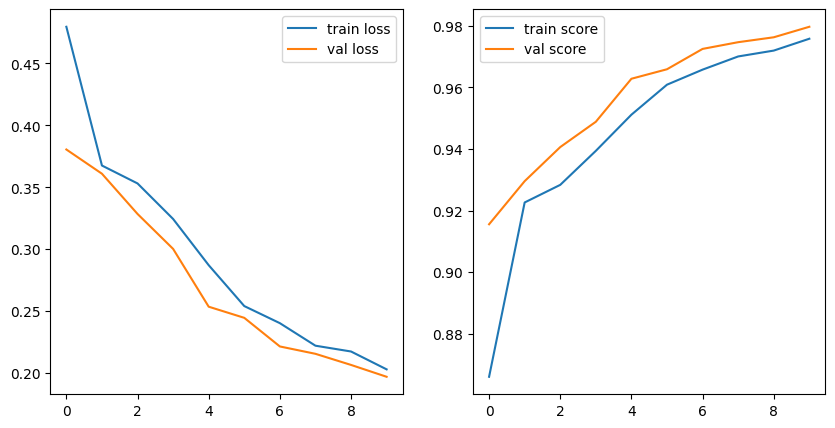


Best Epoch: 10
best_train_loss: 0.2031
best_train_score: 0.9758
best_val_loss: 0.1971
best_val_score: 0.9797



In [56]:
# training process for LSTM model
# the task can be binary classification.
# so the loss function is Binary Cross Entropy
# and optimizer is Adam

# define the model
lstm = model_LSTM(input_size=6, hidden_size=128, num_layers=2, output_size=1, isBidirectional=False, dropout=0.2)
lstm.to(device)
# train epochs
epochs = 10
# define the loss function
loss_func = nn.BCEWithLogitsLoss()
# define the optimizer
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)
# define the scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# training and validation loop
train(lstm, epochs, loss_func, optimizer, scheduler)


Epoch: 1/10...Validation...: 100%|██████████| 185/185 [00:31<00:00,  5.95it/s]



Epoch: 1/10...
avg_train_loss: 0.4656
avg_train_score: 0.8756
avg_val_loss: 0.3620
avg_val_score: 0.9290



Epoch: 2/10...Validation...: 100%|██████████| 185/185 [00:30<00:00,  5.99it/s]



Epoch: 2/10...
avg_train_loss: 0.3669
avg_train_score: 0.9232
avg_val_loss: 0.3413
avg_val_score: 0.9347



Epoch: 3/10...Validation...: 100%|██████████| 185/185 [00:30<00:00,  5.99it/s]



Epoch: 3/10...
avg_train_loss: 0.3491
avg_train_score: 0.9304
avg_val_loss: 0.3252
avg_val_score: 0.9408



Epoch: 4/10...Validation...: 100%|██████████| 185/185 [00:30<00:00,  6.00it/s]



Epoch: 4/10...
avg_train_loss: 0.3182
avg_train_score: 0.9415
avg_val_loss: 0.2855
avg_val_score: 0.9540



Epoch: 5/10...Validation...: 100%|██████████| 185/185 [00:31<00:00,  5.93it/s]



Epoch: 5/10...
avg_train_loss: 0.2844
avg_train_score: 0.9535
avg_val_loss: 0.2698
avg_val_score: 0.9614



Epoch: 6/10...Validation...: 100%|██████████| 185/185 [00:30<00:00,  6.01it/s]



Epoch: 6/10...
avg_train_loss: 0.2607
avg_train_score: 0.9595
avg_val_loss: 0.2460
avg_val_score: 0.9655



Epoch: 7/10...Validation...: 100%|██████████| 185/185 [00:30<00:00,  6.07it/s]



Epoch: 7/10...
avg_train_loss: 0.2455
avg_train_score: 0.9642
avg_val_loss: 0.2359
avg_val_score: 0.9687



Epoch: 8/10...Validation...: 100%|██████████| 185/185 [00:30<00:00,  6.01it/s]



Epoch: 8/10...
avg_train_loss: 0.2375
avg_train_score: 0.9672
avg_val_loss: 0.2219
avg_val_score: 0.9716



Epoch: 9/10...Validation...: 100%|██████████| 185/185 [00:30<00:00,  5.99it/s]



Epoch: 9/10...
avg_train_loss: 0.2237
avg_train_score: 0.9704
avg_val_loss: 0.2147
avg_val_score: 0.9741



Epoch: 10/10...Validation...: 100%|██████████| 185/185 [00:30<00:00,  6.02it/s]



Epoch: 10/10...
avg_train_loss: 0.2154
avg_train_score: 0.9728
avg_val_loss: 0.2076
avg_val_score: 0.9757



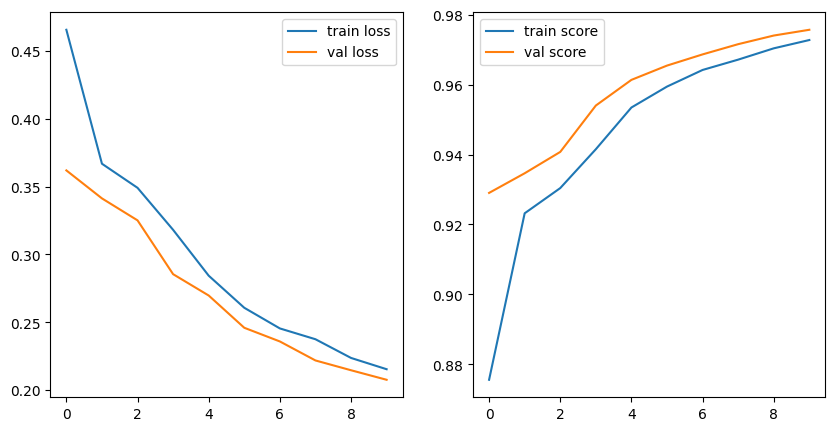


Best Epoch: 10
best_train_loss: 0.2154
best_train_score: 0.9728
best_val_loss: 0.2076
best_val_score: 0.9757



In [57]:
# training process for GRU model
# the task can be binary classification.
# so the loss function is Binary Cross Entropy
# and optimizer is Adam

# define the model
gru = model_GRU(input_size=6, hidden_size=128, num_layers=2, output_size=1, isBidirectional=False, dropout=0.2)
gru.to(device)
# train epochs
epochs = 10
# define the loss function
loss_func = nn.BCEWithLogitsLoss()
# define the optimizer
optimizer = torch.optim.Adam(gru.parameters(), lr=0.001)
# define the scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# training and validation loop
train(gru, epochs, loss_func, optimizer, scheduler)



### CNN models training and test

classcial 2D convolutional neural network can not handle the time series data, so we need to use 1D convolutional neural network to train the time series data.

In [43]:
# define the CNN model
class Conv1dCNN(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=2), # 50 - 2 + 1 = 49
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=1) # 49 - 2 + 1 = 48
        )

        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=2), # 48 - 2 + 1 = 47
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=1) # 47 - 2 + 1 = 46
        )

        self.fc = outputLayer_doubleMLP(64 * 46, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        # batch, feature_dim, seq_len
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1) # flatten, shape: (batch, 64 * 46)
        pred1, pred2 = self.fc(x)
        pred = torch.cat((pred1, pred2), 1)
        return pred
    
    def name(self):
        return self.__class__.__name__
    
    def save(self, path):
        torch.save(self.state_dict(), path)

    def load(self, path):
        self.load_state_dict(torch.load(path))


Epoch: 1/10...Validation...: 100%|██████████| 185/185 [00:06<00:00, 27.52it/s]



Epoch: 1/10...
avg_train_loss: 0.3797
avg_train_score: 0.9174
avg_val_loss: 0.3346
avg_val_score: 0.9541



Epoch: 2/10...Validation...: 100%|██████████| 185/185 [00:06<00:00, 28.43it/s]



Epoch: 2/10...
avg_train_loss: 0.2794
avg_train_score: 0.9582
avg_val_loss: 0.2632
avg_val_score: 0.9606



Epoch: 3/10...Validation...: 100%|██████████| 185/185 [00:06<00:00, 28.07it/s]



Epoch: 3/10...
avg_train_loss: 0.2480
avg_train_score: 0.9667
avg_val_loss: 0.2372
avg_val_score: 0.9698



Epoch: 4/10...Validation...: 100%|██████████| 185/185 [00:06<00:00, 28.93it/s]



Epoch: 4/10...
avg_train_loss: 0.2321
avg_train_score: 0.9710
avg_val_loss: 0.2246
avg_val_score: 0.9712



Epoch: 5/10...Validation...: 100%|██████████| 185/185 [00:06<00:00, 28.41it/s]



Epoch: 5/10...
avg_train_loss: 0.2179
avg_train_score: 0.9736
avg_val_loss: 0.2136
avg_val_score: 0.9741



Epoch: 6/10...Validation...: 100%|██████████| 185/185 [00:06<00:00, 28.40it/s]



Epoch: 6/10...
avg_train_loss: 0.2001
avg_train_score: 0.9776
avg_val_loss: 0.1976
avg_val_score: 0.9783



Epoch: 7/10...Validation...: 100%|██████████| 185/185 [00:06<00:00, 28.97it/s]



Epoch: 7/10...
avg_train_loss: 0.1918
avg_train_score: 0.9795
avg_val_loss: 0.2014
avg_val_score: 0.9769



Epoch: 8/10...Validation...: 100%|██████████| 185/185 [00:06<00:00, 28.55it/s]



Epoch: 8/10...
avg_train_loss: 0.1874
avg_train_score: 0.9805
avg_val_loss: 0.1928
avg_val_score: 0.9791



Epoch: 9/10...Validation...: 100%|██████████| 185/185 [00:06<00:00, 28.70it/s]



Epoch: 9/10...
avg_train_loss: 0.1817
avg_train_score: 0.9816
avg_val_loss: 0.1967
avg_val_score: 0.9810



Epoch: 10/10...Validation...: 100%|██████████| 185/185 [00:06<00:00, 28.39it/s]



Epoch: 10/10...
avg_train_loss: 0.1767
avg_train_score: 0.9828
avg_val_loss: 0.1873
avg_val_score: 0.9800



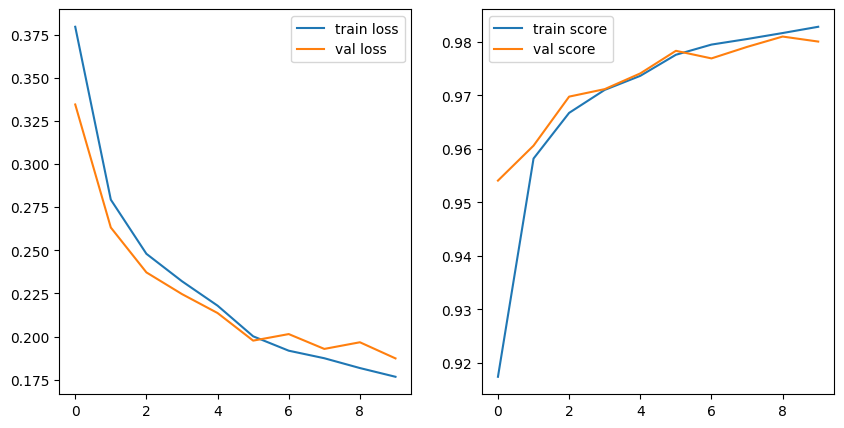


Best Epoch: 10
best_train_loss: 0.1767
best_train_score: 0.9828
best_val_loss: 0.1873
best_val_score: 0.9800



In [59]:
# training process for CNN model
# the task can be binary classification.
# so the loss function is Binary Cross Entropy
# and optimizer is Adam

# define the model
cnn = Conv1dCNN(input_size=6, output_size=1)
cnn.to(device)
# train epochs
epochs = 10
# define the loss function
loss_func = nn.BCEWithLogitsLoss()
# define the optimizer
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
# define the scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# training and validation loop
train(cnn, epochs, loss_func, optimizer, scheduler)

As a result, LSTM, GRU and 1D CNN are used to train the data, and performance are good. And in the test, we can see that the 1D CNN is the best one for this task.
However, the training data and validation data are both from one person, we can test further with more persons data.

In [87]:
# preprocess all person data

# import data processing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# pandas library for data analysis.
# numpy library for numerical operations, like matrix multiplication, etc.
# matplotlib library for data visualization.

import os
import time

# import the pytorch library
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader

# import utils
import re               # regular expression
from tqdm import tqdm   # progress bar
import pickle           # load batch data

data_rootpath = "./data/"

seq_len = 50
feature_dim = 6
batch_size = 128
batch_rootpath = "./cache/"

import shutil
def clean_cache():
    shutil.rmtree(batch_rootpath, ignore_errors=True)
    # recreate the folder
    os.makedirs(batch_rootpath)

from scipy.signal import butter, lfilter
# fs: sampling frequency (Hz)
# cutoff: cutoff frequency (Hz)
# order: order of the filter (default: 5)

# params set for filter
fs = 50.0 # Hz
cutoff = 3 # Hz
order = 3
# fs is 50Hz, which I selected a general sampleing frequency of the IMU sensor.
# cutoff frequency is 3Hz
# when sensor is hold by hand, the frequency can be around 3Hz
# so we set the cutoff frequency to 3Hz to filter the high frequency noise
# 3 order filter is enough for this task

def butter_lowpass(cutoff, fs, order=5):
    # nyq: Nyquist frequency
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    # get the numerator and denominator of the filter
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    # get the numerator and denominator of the filter
    b, a = butter_lowpass(cutoff, fs, order=order)
    # filter the data
    y = lfilter(b, a, data)
    return y

def MinMax_Scaler(X, feature_range=(0, 1)):
    X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    X_rescaled = X_std * (feature_range[1] - feature_range[0]) + feature_range[0]
    return X_rescaled


clean_cache()
data_rootpath = './data/'
batch_rootpath = './cache/'
data_paths = []
test_path = './data/testdata.csv'

for a, _, c in os.walk(data_rootpath):
    for item in c:
        if item.split('.')[0] == 'testdata':
            continue
        else:
            data_paths.append(a + '/' + item)

# seperate feature data and label data
feature_data_paths = []
label_data_paths = []
for path in data_paths:
    if path.endswith('.csv'):
        feature_data_paths.append(path)
    elif path.endswith('.stepMixed'):
        label_data_paths.append(path)
    else:
        print('Unknown file!')
# check
if len(feature_data_paths) != len(label_data_paths):
    print('The number of feature data is not as same as the number of label data!')
for feature_path, label_path in zip(feature_data_paths, label_data_paths):
    if feature_path.split('/')[-1].split('.')[0].split('_')[-1] != \
    label_path.split('/')[-1].split('.')[0].split('_')[-1]:
        print('feature name and label name are not matching!')


batches_index = []
step_data_cnt = 1
max_cnt = len(feature_data_paths)
train_ratio = 0.8

# process test data
if test_path is not None:
    data_name = 'test_data'
    all_seqs = []
    # feature data preprocess
    sample_feature_data = pd.read_csv(test_path)
    try:
        sample_feature_data = sample_feature_data.drop([' Activity'], axis=1)
    except:
        print('The feature data has no column named Activity! ' + data_name)
    sample_feature_data_filtered = sample_feature_data.apply(lambda x: butter_lowpass_filter(x, cutoff, fs, order))
    sample_feature_data_filtered_rescaled = MinMax_Scaler(sample_feature_data_filtered)
    feature_data = sample_feature_data_filtered_rescaled.values
    sequenctial_data = []
    for i in range(len(feature_data)):
        if i - seq_len + 1 < 0:
            padding = np.zeros((seq_len, feature_dim))
            padding[seq_len-1-i:] = feature_data[:i+1]
            sequenctial_data.append(padding)
        else:
            sequenctial_data.append(feature_data[i-seq_len+1:i+1])
    all_seqs = sequenctial_data

    # split batches and save
    data_batches = []
    for i in range(0, len(all_seqs), batch_size):
        data_batches.append(all_seqs[i:i+batch_size])

    batch_saved_paths = []
    batch_cnt = 1
    for item in data_batches:
        save_path = batch_rootpath + data_name + "_batch_{}.pkl".format(batch_cnt)
        with open(save_path, "wb") as f:
            pickle.dump(item, f)
        batch_saved_paths.append(save_path)
        batch_cnt += 1
    batches_index.append([data_name, batch_saved_paths])
    print("{} data finished preprocessing!\n".format(data_name))

for feature_path, label_path in zip(feature_data_paths, label_data_paths):
    if step_data_cnt <= int(max_cnt*train_ratio):
        isShuffle = True
    else:
        isShuffle = False
    if isShuffle:
        data_name = 'step_data_' + str(step_data_cnt) + "_shuffled"
    else:
        data_name = 'step_data_' + str(step_data_cnt) + "_unshuffled"
    step_data_cnt += 1
    
    all_seqs = []
    # feature data preprocess
    sample_feature_data = pd.read_csv(feature_path)
    try:
        sample_feature_data = sample_feature_data.drop([' Activity'], axis=1)
    except:
        print('The feature data has no column named Activity! ' + data_name)
    sample_feature_data_filtered = sample_feature_data.apply(lambda x: butter_lowpass_filter(x, cutoff, fs, order))
    sample_feature_data_filtered_rescaled = MinMax_Scaler(sample_feature_data_filtered)
    feature_data = sample_feature_data_filtered_rescaled.values
    sequenctial_data = []
    for i in range(len(feature_data)):
        if i - seq_len + 1 < 0:
            padding = np.zeros((seq_len, feature_dim))
            padding[seq_len-1-i:] = feature_data[:i+1]
            sequenctial_data.append(padding)
        else:
            sequenctial_data.append(feature_data[i-seq_len+1:i+1])
    # sequenctial_data = np.array(sequenctial_data)

    # label data preprocess
    sample_step_data = pd.read_csv(label_path, header=None)
    start_step_indices = []
    end_step_indices = []
    for i in range(sample_step_data.shape[0]):
        start_step_indices.extend(range(sample_step_data.iloc[i, 0] - 10, sample_step_data.iloc[i, 0] + 10))
        end_step_indices.extend(range(sample_step_data.iloc[i, 1] - 10, sample_step_data.iloc[i, 1] + 10))
    
    label_start_step_data = np.zeros((len(sequenctial_data), 1))
    label_end_step_data = np.zeros((len(sequenctial_data), 1))
    label_start_step_data[start_step_indices] = 1
    label_end_step_data[end_step_indices] = 1
    label_step_data = np.concatenate((label_start_step_data, label_end_step_data), axis=1)

    for i in range(len(sequenctial_data)):
        all_seqs.append([sequenctial_data[i], label_step_data[i]])
    if isShuffle:
        np.random.shuffle(all_seqs)
    
    # split batches and save
    data_batches = []
    for i in range(0, len(all_seqs), batch_size):
        data_batches.append(all_seqs[i:i+batch_size])
    
    batch_saved_paths = []
    batch_cnt = 1
    for item in data_batches:
        save_path = batch_rootpath + data_name + "_batch_{}.pkl".format(batch_cnt)
        with open(save_path, "wb") as f:
            pickle.dump(item, f)
        batch_saved_paths.append(save_path)
        batch_cnt += 1
    batches_index.append([data_name, batch_saved_paths])
    print("{} data finished preprocessing!\n".format(data_name))

# save data index
with open('./data_index.pkl', "wb") as f:
    pickle.dump(batches_index, f)
    

The feature data has no column named Activity! test_data
test_data data finished preprocessing!

step_data_1_shuffled data finished preprocessing!

step_data_2_shuffled data finished preprocessing!

step_data_3_shuffled data finished preprocessing!

step_data_4_shuffled data finished preprocessing!

step_data_5_shuffled data finished preprocessing!

step_data_6_shuffled data finished preprocessing!

step_data_7_shuffled data finished preprocessing!

step_data_8_shuffled data finished preprocessing!

step_data_9_shuffled data finished preprocessing!

step_data_10_shuffled data finished preprocessing!

step_data_11_shuffled data finished preprocessing!

step_data_12_shuffled data finished preprocessing!

step_data_13_shuffled data finished preprocessing!

step_data_14_shuffled data finished preprocessing!

step_data_15_shuffled data finished preprocessing!

step_data_16_shuffled data finished preprocessing!

step_data_17_shuffled data finished preprocessing!

step_data_18_shuffled data f

In [88]:
# check data index
with open('./data_index.pkl', "rb") as f:
    batches_index = pickle.load(f)
    for item in batches_index:
        print("- {}".format(item[0]) + " : {} batches.".format(len(item[1])))
        # for path in item[1]:
        #     print("\t - {}\n\t...\n".format(path))
        #     break


# this part process all the data from all persons,
# and save them into batches, and save the batches' index
# into a file named 'data_index.pkl'
# batch_index can be like:
# [
#     ['step_data_1_shuffled', ['batch1_path', 'batch2_path', ...]],
#     ['step_data_2_shuffled', ['batch1_path', 'batch2_path', ...]],
#     ['step_data_3_unshuffled', ['batch1_path', 'batch2_path', ...]],
#     ...
# ]   


- test_data : 798 batches.
- step_data_1_shuffled : 118 batches.
- step_data_2_shuffled : 221 batches.
- step_data_3_shuffled : 311 batches.
- step_data_4_shuffled : 90 batches.
- step_data_5_shuffled : 121 batches.
- step_data_6_shuffled : 158 batches.
- step_data_7_shuffled : 160 batches.
- step_data_8_shuffled : 165 batches.
- step_data_9_shuffled : 190 batches.
- step_data_10_shuffled : 228 batches.
- step_data_11_shuffled : 200 batches.
- step_data_12_shuffled : 258 batches.
- step_data_13_shuffled : 262 batches.
- step_data_14_shuffled : 185 batches.
- step_data_15_shuffled : 245 batches.
- step_data_16_shuffled : 207 batches.
- step_data_17_shuffled : 313 batches.
- step_data_18_shuffled : 130 batches.
- step_data_19_shuffled : 202 batches.
- step_data_20_shuffled : 222 batches.
- step_data_21_shuffled : 161 batches.
- step_data_22_shuffled : 274 batches.
- step_data_23_unshuffled : 151 batches.
- step_data_24_unshuffled : 177 batches.
- step_data_25_unshuffled : 88 batches.
- s

In [90]:
# shuffled data is for training
# unshuffled data is for validation
train_batches_index = []
valid_batches = []
test_batches_index = []

# load data index
with open('./data_index.pkl', "rb") as f:
    batches_index = pickle.load(f)
    for item in batches_index:
        if item[0].endswith('_shuffled'):
            train_batches_index.extend(item[1])
        elif item[0].endswith('_unshuffled'):
            valid_batches.append(item)
        else:
            test_batches_index.extend(item[1])

print("train batches: {}".format(len(train_batches_index)))
print("valid batches: {}".format(len(valid_batches)))
print("test batches: {}".format(len(test_batches_index)))

# the train batches extend all the shuffled data batches
# the valid batches includes all the unshuffled data batches seperated by step_data

train batches: 4421
valid batches: 6
test batches: 798


In [95]:
# new training process for multi-person
model_save_path = './models/'
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)

def train(model, num_epochs, criterion, optimizer, scheduler):
    total_train_loss = []
    total_train_score = []
    total_val_loss = []
    total_val_score = []
    for e in range(num_epochs):
        avg_train_loss = 0
        avg_train_score = 0
        avg_val_loss = 0
        avg_val_score = 0

        # shuffle batch
        np.random.shuffle(train_batches_index)
        batches_for_training = train_batches_index[:int(len(train_batches_index)*0.1)]


        with tqdm(total=len(batches_for_training)+len(valid_batches)) as pbar:

            # training
            pbar.set_description('Epoch: {}/{}...'.format(e+1, num_epochs)+'Training...')
            for batch_file in batches_for_training:
                # train mode
                model.train()

                # load batch data
                with open(batch_file, 'rb') as f:
                    batch_data = pickle.load(f)
                feature = torch.tensor([row[0] for row in batch_data], dtype=torch.float32).to(device)
                label = torch.tensor([row[1] for row in batch_data], dtype=torch.float32).to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                pred = model(feature)

                # backward
                loss = criterion(pred, label)
                avg_train_loss += loss.item()
                loss.backward()

                # update parameters
                optimizer.step()

                # calculate the score
                pred = torch.sigmoid(pred)
                AP_start = metrics.average_precision_score(
                    label[:, 0].reshape(-1, 1).cpu().detach().numpy(),
                    pred[:, 0].reshape(-1, 1).cpu().detach().numpy()
                )
                AP_end = metrics.average_precision_score(
                    label[:, 1].reshape(-1, 1).cpu().detach().numpy(),
                    pred[:, 1].reshape(-1, 1).cpu().detach().numpy()
                )
                avg_train_score += (AP_start + AP_end) / 2.0

                pbar.update(1) # update progress bar
            
            # validation
            pbar.set_description('Epoch: {}/{}...'.format(e+1, num_epochs)+'Validation...')
            batches_cnt = 0
            with torch.no_grad():
                for person_for_valid in valid_batches:
                    valid_result = []
                    # get all label from batches
                    true_label = []
                    for batch_file in person_for_valid[1]:
                        # eval mode
                        model.eval()

                        # load batch data
                        with open(batch_file, 'rb') as f:
                            batch_data = pickle.load(f)
                        
                        feature = torch.tensor([row[0] for row in batch_data], dtype=torch.float32).to(device)
                        label = torch.tensor([row[1] for row in batch_data], dtype=torch.float32).to(device)
                        true_label.append(label)

                        # forward
                        pred = model(feature)
                        pred = torch.sigmoid(pred)

                        valid_result.append(pred)

                        # calculate the loss
                        loss = criterion(pred, label)
                        avg_val_loss += loss.item()
                        batches_cnt += 1
                    pbar.update(1) # update progress bar

                    # calculate the score
                    valid_result = torch.vstack(valid_result)
                    true_label = torch.vstack(true_label)
                    AP_start = metrics.average_precision_score(
                        true_label[:, 0].reshape(-1, 1).cpu().detach().numpy(),
                        valid_result[:, 0].reshape(-1, 1).cpu().detach().numpy()
                    )
                    AP_end = metrics.average_precision_score(
                        true_label[:, 1].reshape(-1, 1).cpu().detach().numpy(),
                        valid_result[:, 1].reshape(-1, 1).cpu().detach().numpy()
                    )
                    AP_score = (AP_start + AP_end) / 2.0
                    avg_val_score += AP_score

        total_train_loss.append(avg_train_loss / len(batches_for_training))
        total_train_score.append(avg_train_score / len(batches_for_training))
        total_val_loss.append(avg_val_loss / batches_cnt)
        total_val_score.append(avg_val_score / len(person_for_valid))
        # print the training and validation loss and score
        epoch_info = 'avg_train_loss: {:.4f}\n'.format(total_train_loss[-1])+\
            'avg_train_score: {:.4f}\n'.format(total_train_score[-1])+\
            'avg_val_loss: {:.4f}\n'.format(total_val_loss[-1])+\
            'avg_val_score: {:.4f}\n'.format(total_val_score[-1])
        print(epoch_info)

        # save the model
        model.save(model_save_path+model.name()+'_epoch{}.pth'.format(e+1))

        # update the learning rate
        scheduler.step()

    # plot the training and validation loss and score
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(total_train_loss, label='train loss')
    plt.plot(total_val_loss, label='val loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(total_train_score, label='train score')
    plt.plot(total_val_score, label='val score')
    plt.legend()
    plt.show()

    # print the best training and validation loss and score
    best_epoch = np.argmin(total_val_loss)
    best_info = '\nBest Epoch: {}\n'.format(best_epoch+1)+\
        'best_train_loss: {:.4f}\n'.format(total_train_loss[best_epoch])+\
        'best_train_score: {:.4f}\n'.format(total_train_score[best_epoch])+\
        'best_val_loss: {:.4f}\n'.format(total_val_loss[best_epoch])+\
        'best_val_score: {:.4f}\n'.format(total_val_score[best_epoch])
    print(best_info)

# in this training function, only part of persons data used for training
# and randomly select one person, then used all the batches of this person for validation

In [96]:
# training process for CNN model

# define the model
cnn = Conv1dCNN(input_size=6, output_size=1)
cnn.to(device)
# train epochs
epochs = 10
# define the loss function
loss_func = nn.BCEWithLogitsLoss()
# define the optimizer
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
# define the scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# training and validation loop
train(cnn, epochs, loss_func, optimizer, scheduler)

Epoch: 1/10...Validation...: 100%|██████████| 448/448 [00:44<00:00,  9.99it/s]


avg_train_loss: 0.4604
avg_train_score: 0.7975
avg_val_loss: 0.7026
avg_val_score: 2.0702



Epoch: 2/10...Training...:  32%|███▏      | 143/448 [00:06<00:13, 23.44it/s]


KeyboardInterrupt: 